# 05: Unstructred Grids

This notebook demonstrates FloPy functionality for creating different types of model grids.  Six different model grids are constructed for the same domain.  The domain is defined by a polygon intended to represent a hydrologic basin.

The grids generated in this notebook include the following:

* Regular MODFLOW grid
* Irregular MODFLOW grid with variable row and column spacings
* Nested grid, consisting of parent and child grids
* Quadtree grid created using the FloPy wrapper for the [USGS Gridgen program](https://www.usgs.gov/software/gridgen-program-generating-unstructured-finite-volume-grids)
* Triangular grid created using the FloPy wrapper for the [Triangle program](https://www.cs.cmu.edu/~quake/triangle.html).
* Voronoi grid created using the [Triangle program](https://www.cs.cmu.edu/~quake/triangle.html) and the [Scipy voronoi class](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html#scipy.spatial.Voronoi)  

## Notebook Setup

In [1]:
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import flopy
from flopy.discretization import StructuredGrid, VertexGrid
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from flopy.utils.gridgen import Gridgen

In [2]:
# import basin data and utilities from basin.py
import basin

In [3]:
temp_path = pl.Path("./temp")
temp_path.mkdir(exist_ok=True, parents=True)

## Basin Example

len boundary 55
Len segment:  38
Len segment:  14
Len segment:  12
Len segment:  13


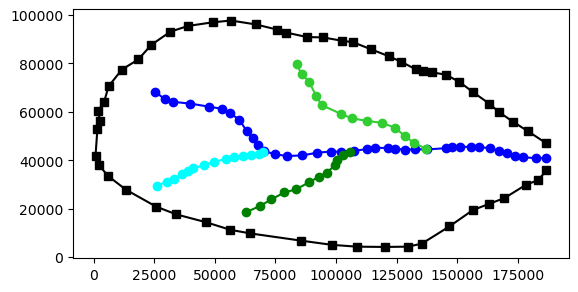

In [4]:
boundary_polygon = basin.string2geom(basin.boundary)
print("len boundary", len(boundary_polygon))
bp = np.array(boundary_polygon)

sgs = [
    basin.string2geom(sg) for sg in (
        basin.streamseg1, basin.streamseg2, basin.streamseg3, basin.streamseg4
        )
]

fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect("equal")

ax.plot(bp[:, 0], bp[:, 1], "ks-")
colors = ("blue", "cyan", "green", "limegreen")
for idx, sg in enumerate(sgs):
    print("Len segment: ", len(sg))
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], marker="o", color=colors[idx])

## FloPy `StructuredGrid`

180000 100000 50 90


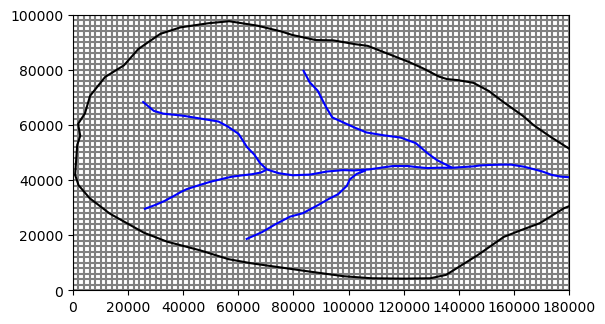

In [5]:
# Create a regular MODFLOW grid
Lx = 180000
Ly = 100000
dx = dy = 2000
nrow = int(Ly / dy)
ncol = int(Lx / dx)
print(Lx, Ly, nrow, ncol)
delr = np.array(ncol * [dx])
delc = np.array(nrow * [dy])
regular_grid = StructuredGrid(delr=delr, delc=delc, xoff=0.0, yoff=0.0)

fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect("equal")
regular_grid.plot(ax=ax)
ax.plot(bp[:, 0], bp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-")

In [6]:
def set_idomain(grid, boundary):
    from flopy.utils.gridintersect import GridIntersect
    from shapely.geometry import Polygon

    ix = GridIntersect(grid, method="vertex", rtree=True)
    result = ix.intersect(Polygon(boundary))
    idx = [coords for coords in result.cellids]
    idx = np.array(idx, dtype=int)
    nr = idx.shape[0]
    if idx.ndim == 1:
        idx = idx.reshape((nr, 1))
    print(idx.shape, idx.ndim)
    idx = tuple([idx[:, i] for i in range(idx.shape[1])])
    # idx = (idx[:, 0], idx[:, 1])
    idomain = np.zeros(grid.shape[1:], dtype=int)
    idomain[idx] = 1
    idomain = idomain.reshape(grid.shape)
    grid.idomain = idomain

### Regular MODFLOW Grid (DIS)

180000 100000 50 90


(3194, 2) 2


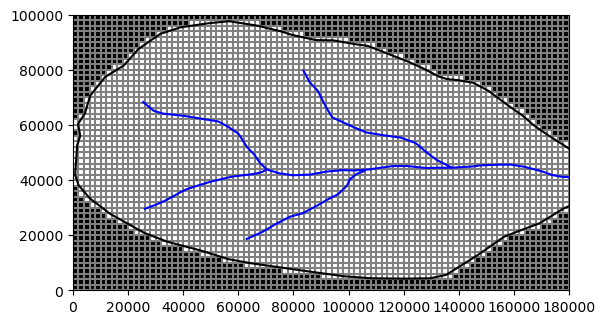

In [7]:
# Create a regular MODFLOW grid
Lx = 180000
Ly = 100000
dx = dy = 2000
nrow = int(Ly / dy)
ncol = int(Lx / dx)
print(Lx, Ly, nrow, ncol)
delr = np.array(ncol * [dx])
delc = np.array(nrow * [dy])
regular_grid = StructuredGrid(nlay=1, delr=delr, delc=delc, xoff=0.0, yoff=0.0)

set_idomain(regular_grid, boundary_polygon)

fig = plt.figure()
ax = fig.add_subplot()
pmv = flopy.plot.PlotMapView(modelgrid=regular_grid)
ax.set_aspect("equal")
pmv.plot_grid()
pmv.plot_inactive()
# regular_grid.plot(ax=ax, )
ax.plot(bp[:, 0], bp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-")

### Irregular Grid (DIS)

(1826, 2) 2


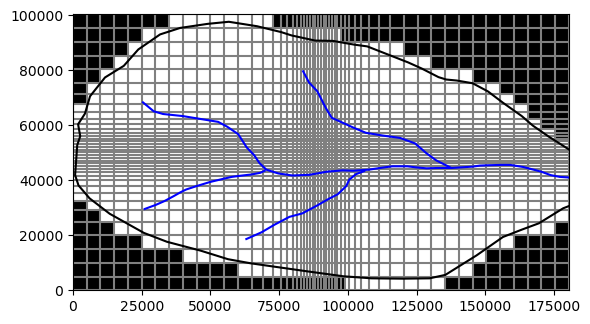

In [8]:
# Create an irregular MODFLOW grid
Lx = 180000
Ly = 100000
dx = dy = 5000

smooth = [5000 / 1.2**i for i in range(9)]
smoothr = smooth.copy()
smoothr.reverse()
dx = 12 * [5000] + smooth + 12 * [1000] + smoothr + 12 * [5000]
dy = 4 * [5000] + smooth + 12 * [1000] + smoothr + 4 * [5000]

ncol = len(dx)
nrow = len(dy)

delr = np.array(dx)
delc = np.array(dy)
irregular_grid = StructuredGrid(
    nlay=1, delr=delr, delc=delc, xoff=0.0, yoff=0.0
)
set_idomain(irregular_grid, boundary_polygon)

fig = plt.figure()
ax = fig.add_subplot()
pmv = flopy.plot.PlotMapView(modelgrid=irregular_grid)
ax.set_aspect("equal")
pmv.plot_grid()
pmv.plot_inactive()
ax.plot(bp[:, 0], bp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-")

### Nested grid - two regular grids (DIS)

(548, 2) 2


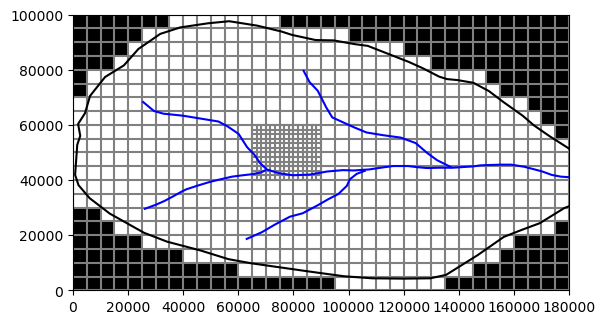

In [9]:
# nested grid
from flopy.utils.lgrutil import Lgr

# define parent grid information
nlayp = 1
dx = 5000
nrowp = int(Ly / dx)
ncolp = int(Lx / dx)
delrp = dx
delcp = dx
topp = 1.0
botmp = [0.0]
idomainp = np.ones((nlayp, nrowp, ncolp), dtype=int)
idomainp[0, 8:12, 13:18] = 0

# define child grid resolution parameters
ncpp = 3
ncppl = [1]

lgr = Lgr(
    nlayp,
    nrowp,
    ncolp,
    delrp,
    delcp,
    topp,
    botmp,
    idomainp,
    ncpp=ncpp,
    ncppl=ncppl,
    xllp=0.0,
    yllp=0.0,
)

delr = np.array(ncolp * [dx])
delc = np.array(nrowp * [dx])
regular_gridp = StructuredGrid(nlay=1, delr=delr, delc=delc, idomain=idomainp)
set_idomain(regular_gridp, boundary_polygon)

delr, delc = lgr.get_delr_delc()
xoff, yoff = lgr.get_lower_left()
regular_gridc = StructuredGrid(
    delr=delr, delc=delc, xoff=xoff, yoff=yoff, idomain=idomainp
)

nested_grid = [regular_gridp, regular_gridc]

fig = plt.figure()
ax = fig.add_subplot()
pmv = flopy.plot.PlotMapView(modelgrid=regular_gridp)
pmv.plot_inactive()
ax.set_aspect("equal")
regular_gridc.plot(ax=ax)
pmv.plot_grid()

# regular_gridp.plot(ax=ax)

ax.plot(bp[:, 0], bp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-")

## FloPy `VertexGrid`

### Quadtree Grid (DISV)

(1454, 1) 2


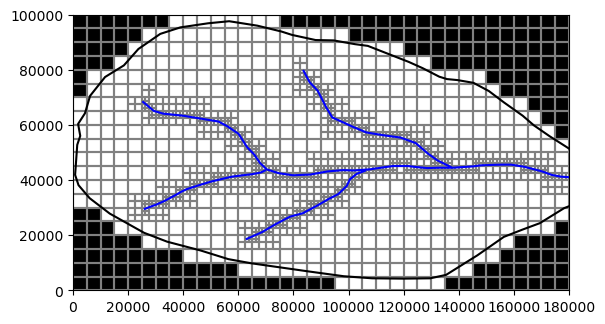

In [10]:
# quadtree grid
sim = flopy.mf6.MFSimulation()
gwf = flopy.mf6.ModflowGwf(sim)
dx = dy = 5000.0
nr = int(Ly / dy)
nc = int(Lx / dx)
dis6 = flopy.mf6.ModflowGwfdis(
    gwf,
    nrow=nr,
    ncol=nc,
    delr=dy,
    delc=dx,
)

# Create gridgen object, add refinement features, and build grid
g = Gridgen(gwf.modelgrid, model_ws=temp_path)
refine_line = sgs
g.add_refinement_features(refine_line, "line", 2, range(1))
g.build(verbose=False)

gridprops_vg = g.get_gridprops_vertexgrid()
quadtree_grid = flopy.discretization.VertexGrid(**gridprops_vg)
set_idomain(quadtree_grid, boundary_polygon)

fig = plt.figure()
ax = fig.add_subplot()
pmv = flopy.plot.PlotMapView(modelgrid=quadtree_grid)
pmv.plot_grid()
pmv.plot_inactive()
ax.set_aspect("equal")

ax.plot(bp[:, 0], bp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-")

### Triangular grid (DISV)

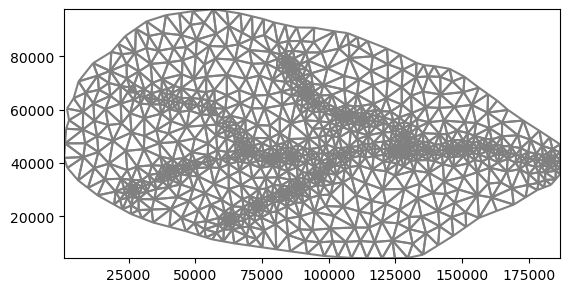

In [11]:
# Set maximum cell area
maximum_area = 5000 * 5000

nodes = []
for sg in sgs:
    sg_densify = basin.densify_geometry(sg, 2000)
    nodes += sg_densify
nodes = np.array(nodes)

# Use the flopy Triangle class to build a triangular mesh
tri = Triangle(angle=30, maximum_area=maximum_area, nodes=nodes, model_ws=temp_path)
poly = bp
tri.add_polygon(poly)
tri.build(verbose=False)

# Create a flopy VertexGrid
cell2d = tri.get_cell2d()
vertices = tri.get_vertices()
idomain = np.ones((1, tri.ncpl), dtype=int)
triangular_grid = VertexGrid(vertices=vertices, cell2d=cell2d, idomain=idomain)

fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect("equal")
triangular_grid.plot(ax=ax)

if False:
    ax.plot(bp[:, 0], bp[:, 1], "k-")
    for sg in sgs:
        sa = np.array(sg)
        ax.plot(sa[:, 0], sa[:, 1], "b-")

### Voronoi Grid (DISV)

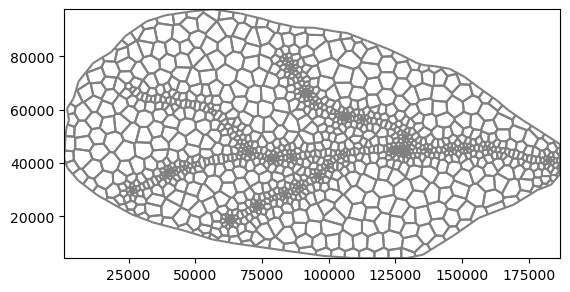

In [12]:
maximum_area = 5000 * 5000

nodes = []
for sg in sgs:
    sg_densify = basin.densify_geometry(sg, 2000)
    nodes += sg_densify
nodes = np.array(nodes)

# Use the flopy Triangle class to build a triangular mesh
tri = Triangle(angle=30, maximum_area=maximum_area / 1, nodes=nodes, model_ws=temp_path)
poly = bp
tri.add_polygon(poly)
tri.build(verbose=False)

# Create the flopy Voronoi grid object and the flopy VertexGrid
vor = VoronoiGrid(tri)
gridprops = vor.get_gridprops_vertexgrid()
idomain = np.ones((1, vor.ncpl), dtype=int)
voronoi_grid = VertexGrid(**gridprops, nlay=1, idomain=idomain)

fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect("equal")
voronoi_grid.plot(ax=ax)